## For some variables, it would be more useful to know the relationship between them at *daily* scales rather than using monthly averages. 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 26 Oct 2020 <br><br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats


## 1. Read in data 

Note that for the UV daily data, since this is such a large dataset, only the lowest three levels were selected via the NCO command: <br> 
<i>ncrcat -d lev,950.0,999.0 -v U,V f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.199* f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.1990-99_sfcLevs-dailyUV.nc</i> <br><br>
Once those files have been read in here, a new pickle file is created that contains the total surface wind speed, rather than U and V seperately. Once that pickle file is available, the original UV files will be deleted. 

In [2]:
# Set up directories 
dataDir    = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.'
nameEnd_UV = '_sfcLevs-dailyUV.nc'
nameEnd_FLX  = '_dailySfcFluxes.nc'

decadeList = ['1970-79','1980-89','1990-99']
#decadeList = ['1990-99']

In [3]:
# Read in single history file to get lat/lon and masks 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Ideally, want to mask out Greenland/Antarctica too (ice sheets)
iceContent = testDF.ICE_CONTENT1.values[0,:,:]  # "Initial gridcell total ice content"
iceMask    = np.full([len(lat),len(lon)], np.nan)
iceMask[iceContent<10000] = 1

<ipython-input-3-a62247b44c48>:16: RuntimeWarning: invalid value encountered in less
  iceMask[iceContent<10000] = 1


In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
#     UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
#     windDF = xr.open_dataset(UVfile, decode_times=True)
#     windDF['time'] = windDF.indexes['time'].to_datetimeindex()   
    
    FLXfile = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
    flxDF   = xr.open_dataset(FLXfile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
#         fullUV   = windDF
        fullFLX  = flxDF
    else:
#         fullUV   = xr.concat([fullUV, windDF], dim="time")
        fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
        
    # Close files 
#     windDF.close() 
    flxDF.close()

        
    print('Done with decade ', decadeList[iDec], ' ... ')

<ipython-input-4-e5f272e26ea6>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()


Done with decade  1970-79  ... 
Done with decade  1980-89  ... 
Done with decade  1990-99  ... 


In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(flxDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 


In [6]:
# Read into individual arrays for easy access
SHFLX = fullFLX.SHFLX.values
LHFLX = fullFLX.LHFLX.values
# U     = fullUV.U.values              # Zonal wind (m/s)
# V     = fullUV.V.values              # Meridional wind (m/s)

# # Flip along vertical (level) axis, so that index 0 is surface 
# U   = np.flip(U, axis=1)
# V   = np.flip(V, axis=1)

# # Save levels themselves to arrays and flip them 
# lev_middle    = np.flip(fullUV.lev.values)


In [7]:
# Now get surface wind magnitude and combine variances 
# windSpd = np.sqrt(U**2 + V**2)


In [8]:
# # Save wind speed out to a pickle file
# fileOutName = dataDir+decadeList[0]+'_totalWindSpeeds.p'
# pickle.dump( [windSpd,lev_middle], open( fileOutName, "wb" ), protocol=4 )
# print('Saved file: ', fileOutName)


Saved file:  /Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/1990-99_totalWindSpeeds.p


Now read in pickle files that contain total surface wind speeds. 

In [7]:
# Load wind speed from pickle file:
windSpd = np.full([np.shape(SHFLX)[0], 3, len(lat), len(lon)], np.nan)  # (all times, 3 levels, lat, lon)

iStartTime = 0 
for iDec in range(len(decadeList)):
    # Read in file for one decade
    fileOutName              = dataDir+decadeList[iDec]+'_totalWindSpeeds.p'
    
    with open(fileOutName, "rb") as f:
        windSpd_temp, lev_middle = pickle.load(f)
    
    # Save to larger array 
    nTime      = np.shape(windSpd_temp)[0]
    windSpd[iStartTime:nTime+iStartTime,:,:,:] = windSpd_temp
    iStartTime = iStartTime+nTime
    

## 2. Carry out linear regression

In [8]:
def linRegress3D(xVar, yVar):
    
    # Get length of lat/lon dimensions 
    shapeDat = np.shape(xVar)
    nlat     = shapeDat[1]
    nlon     = shapeDat[2]
    
    # Define empty arrays to return 
    slope     = np.full([nlat, nlon], np.nan)
    intercept = np.full([nlat, nlon], np.nan)
    rValue    = np.full([nlat, nlon], np.nan)
    pValue    = np.full([nlat, nlon], np.nan)
    
    for ilat in range(len(lat)):
        for ilon in range(len(lon)): 
            x = xVar[:,ilat,ilon]
            y = yVar[:,ilat,ilon]

            # Perform linear regression
            slope[ilat,ilon], intercept[ilat,ilon], rValue[ilat,ilon], pValue[ilat,ilon], std_err = stats.linregress(x, y)


    return(slope,intercept,rValue,pValue)


In [9]:
# Pull out surface layer of wind speed
#   Levels are: [992.56, 976.33, 957.49] 
sfcWindSpd      = windSpd[:,0,:,:]

# Use only land points... (and exclude ice sheets)
sfcWindSpd_land = sfcWindSpd*landMask*iceMask
SHFLX_land      = SHFLX*landMask*iceMask
LHFLX_land      = LHFLX*landMask*iceMask

# Also consider using the bowen ratio or EF rather than fluxes individually (more holistic energy concept)
EF_land         = LHFLX_land / (LHFLX_land + SHFLX_land)
bowen_land      = SHFLX_land / LHFLX_land


In [10]:
# Get seasonal indices 
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]


In [11]:
# Now pick out JJA values: 
sfcWindSpd_JJA = sfcWindSpd_land[iJJA,:,:]
SHFLX_JJA      = SHFLX_land[iJJA,:,:]
LHFLX_JJA      = LHFLX_land[iJJA,:,:]
EF_JJA         = EF_land[iJJA,:,:]
bowen_JJA      = bowen_land[iJJA,:,:]


In [13]:
# Linear regression between mean wind speed and SHFLX 
slope_SpdSHF_JJA,intercept_SpdSHF_JJA,rValue_SpdSHF_JJA,pValue_SpdSHF_JJA = linRegress3D(sfcWindSpd_JJA, np.abs(SHFLX_JJA))

# Linear regression between mean wind speed and LHFLX
slope_SpdLHF_JJA,intercept_SpdLHF_JJA,rValue_SpdLHF_JJA,pValue_SpdLHF_JJA = linRegress3D(sfcWindSpd_JJA, np.abs(LHFLX_JJA))
print('...Regression between wind speed and surface fluxes completed...')

# Linear regression between mean wind speed and evaporative fraction 
slope_SpdEF_JJA,intercept_SpdEF_JJA,rValue_SpdEF_JJA,pValue_SpdEF_JJA = linRegress3D(sfcWindSpd_JJA, EF_JJA)

# Linear regresion between mean wind speed and bowen ratio 
slope_SpdBowen_JJA,intercept_SpdBowen_JJA,rValue_SpdBowen_JJA,pValue_SpdBowen_JJA = linRegress3D(sfcWindSpd_JJA, bowen_JJA)
print('...Regression between wind speed and EF/Bowen ratio completed...')


...Regression between wind speed and surface fluxes completed...
...Regression between wind speed and EF/Bowen ratio completed...


## 3. Check out where correlation coefficients - higher?

In [14]:
print(len(np.where(np.isfinite(rValue_SpdSHF_JJA)==True)[0]))
print(len(np.where(np.isfinite(rValue_SpdLHF_JJA)==True)[0]))
print(len(np.where(np.isfinite(rValue_SpdEF_JJA)==True)[0]))
print(len(np.where(np.isfinite(rValue_SpdBowen_JJA)==True)[0]))


14035
14035
14035
14035


In [16]:
threshold = 0.7
print(len(np.where(np.abs(rValue_SpdSHF_JJA)>=threshold)[0]))
print(len(np.where(np.abs(rValue_SpdLHF_JJA)>=threshold)[0]))
print(len(np.where(np.abs(rValue_SpdEF_JJA)>=threshold)[0]))
print(len(np.where(np.abs(rValue_SpdBowen_JJA)>=threshold)[0]))

78
717
211
194


<ipython-input-16-c31fa9562821>:2: RuntimeWarning: invalid value encountered in greater_equal
  print(len(np.where(np.abs(rValue_SpdSHF_JJA)>=threshold)[0]))
<ipython-input-16-c31fa9562821>:3: RuntimeWarning: invalid value encountered in greater_equal
  print(len(np.where(np.abs(rValue_SpdLHF_JJA)>=threshold)[0]))
<ipython-input-16-c31fa9562821>:4: RuntimeWarning: invalid value encountered in greater_equal
  print(len(np.where(np.abs(rValue_SpdEF_JJA)>=threshold)[0]))
<ipython-input-16-c31fa9562821>:5: RuntimeWarning: invalid value encountered in greater_equal
  print(len(np.where(np.abs(rValue_SpdBowen_JJA)>=threshold)[0]))


In [25]:
# Define threshold for cutting off values of slopes as 'significant'
threshold = 0.70 

# Get fraction of correlation coefficients above threshold 
spdSHF_JJA_count   = len(np.where(np.abs(rValue_SpdSHF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdSHF_JJA)==True)[0])
spdLHF_JJA_count   = len(np.where(np.abs(rValue_SpdLHF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdLHF_JJA)==True)[0])
spdEF_JJA_count    = len(np.where(np.abs(rValue_SpdEF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdEF_JJA)==True)[0])
spdBowen_JJA_count = len(np.where(np.abs(rValue_SpdBowen_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdBowen_JJA)==True)[0])

# Print some summary values 
print('Fraction of correlation coefficients > %.2f: ' % (threshold))
print('   SpdSHF_JJA:   %.4f' % (spdSHF_JJA_count))
print('   SpdLHF_JJA:   %.4f' % (spdLHF_JJA_count))
print('   SpdEF_JJA:    %.4f' % (spdEF_JJA_count))
print('   SpdBowen_JJA: %.4f' % (spdBowen_JJA_count))


## Define mask based on where corrCoef >= 0.7 for spdVar and varPBL;
#    Mask based on where corrCoef>=0.5 otherwise. 
# maskR_spdSHF = np.full([len(lat), len(lon)], np.nan)
# maskR_spdSHF[np.abs(rValue_SpdSHF_JJA)>=0.5] = 1 

# maskR_spdLHF = np.full([len(lat), len(lon)], np.nan)
# maskR_spdLHF[np.abs(rValue_SpdLHF_JJA)>=0.5] = 1

# maskR_spdEF = np.full([len(lat), len(lon)], np.nan)
# maskR_spdEF[np.abs(rValue_SpdEF_JJA)>=0.5] = 1

# maskR_spdBowen = np.full([len(lat), len(lon)], np.nan)
# maskR_spdBowen[np.abs(rValue_SpdBowen_JJA)>=0.5] = 1



Fraction of correlation coefficients > 0.50: 
   SpdSHF_JJA:   0.0546
   SpdLHF_JJA:   0.1001
   SpdEF_JJA:    0.0576
   SpdBowen_JJA: 0.0583


<ipython-input-25-ad8d71f926a6>:5: RuntimeWarning: invalid value encountered in greater_equal
  spdSHF_JJA_count   = len(np.where(np.abs(rValue_SpdSHF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdSHF_JJA)==True)[0])
<ipython-input-25-ad8d71f926a6>:6: RuntimeWarning: invalid value encountered in greater_equal
  spdLHF_JJA_count   = len(np.where(np.abs(rValue_SpdLHF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdLHF_JJA)==True)[0])
<ipython-input-25-ad8d71f926a6>:7: RuntimeWarning: invalid value encountered in greater_equal
  spdEF_JJA_count    = len(np.where(np.abs(rValue_SpdEF_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdEF_JJA)==True)[0])
<ipython-input-25-ad8d71f926a6>:8: RuntimeWarning: invalid value encountered in greater_equal
  spdBowen_JJA_count = len(np.where(np.abs(rValue_SpdBowen_JJA)>=threshold)[0])/len(np.where(np.isfinite(rValue_SpdBowen_JJA)==True)[0])


In [17]:
'''
Function to plot a map of correlation coefficients. 
Note: If some masking is desired for which correlation coefficients 
      are plotted, apply that prior to submitting to plot call here. 

Inputs: 
     rVals    --> Array of correlation coefficients to plot. 
     lat, lon --> lat/lon of data to map against 
     maxVal   --> Max value to plot (min will be negative of that; center = 0)
     corrStr  --> string used in title of plot to describe the regression variables 
'''

def mapCorrCoef(rVals, lat, lon, maxVal, corrStr):
    
    # Make rVals cyclic for plotting
    rVals_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(rVals, lon)
    
    # ----------- Set up figure ------------------------------------------
    fig, ax1 = plt.subplots(1,1, figsize=(8, 12), 
                            facecolor='w', edgecolor='k',
                            subplot_kw={'projection':ccrs.PlateCarree()})

    # Set limits of plot
    ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # Add coastlines 
    ax1.coastlines(linewidth=0.5,edgecolor='0.25')
    ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
    # --------------------------------------------------------------------
    
    # --------- Plot regions --------------------
    contour_plot = ax1.pcolormesh(lon_cyclic,lat, rVals_cyclic,
                            vmax=maxVal,vmin=-maxVal,
                            cmap = 'seismic')

    ax1.set_title('CorrCoef [JJA]: '+corrStr, fontsize=14)

    # Add colorbar 
    ax_position = ax1.get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
#     # Control number of ticks via 'ticker' in matplotlib 
#     tick_locator = ticker.MaxNLocator(nbins=1)
#     cbar.locator = tick_locator
#     cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('Correlation Coefficient',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    # --------------------------------------

    ax1.axhline(0, color='lightgray')
    
    
    return(ax1)

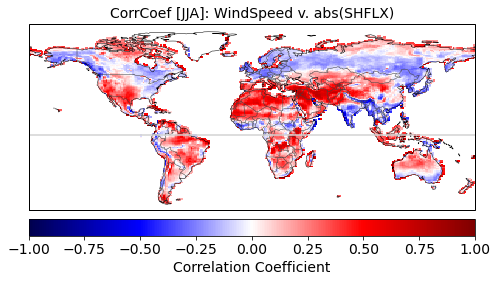

In [18]:
# ------ Map of correlation coefficients: wind speed vs. SHF  ----- 
mapCorrCoef(rValue_SpdSHF_JJA, lat, lon, 1.0, 'WindSpeed v. abs(SHFLX)')

In [23]:
np.shape(rValue_SpdSHF_JJA)

(192, 288)

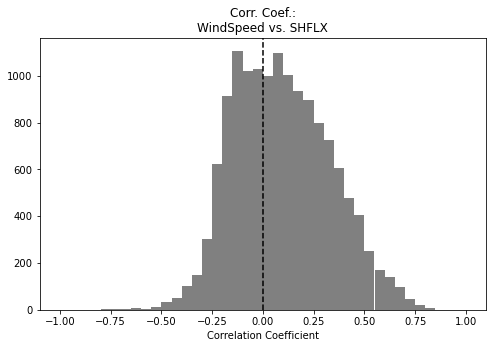

In [25]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5))

# PLOT 1: Correlation coefficients (wind speed vs. abs(SHFLX))
binEdges = np.arange(-1, 1.05, 0.05)

ax1.hist(rValue_SpdSHF_JJA.reshape([len(lat)*len(lon)]), bins=binEdges,facecolor='grey')
ax1.set_xlabel('Correlation Coefficient')
ax1.set_title('Corr. Coef.:\nWindSpeed vs. SHFLX')
ax1.axvline(0, color='k',linestyle='--',label='_hidezero')



## Testing/Debug section

Make sure compiling method for windSpd pickle files functions as expected (doesn't step on previous time step or anything)...

In [17]:
# x = np.asarray([1,2,4,6,3])
# xFull = np.full([len(x)*2], np.nan)

# iStartTime = 0 
# for iDec in range(2):
#     xFull[iStartTime:len(x)+iStartTime] = x 
#     iStartTime = iStartTime+len(x)
    
# xFull


array([1., 2., 4., 6., 3., 1., 2., 4., 6., 3.])